In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


['/device:CPU:0', '/device:GPU:0']


# 0. Loading the data

### TinyImageNet does not have labels for the testing data. We will use the 10k validation images for the testing data.

In [3]:
from tensorflow.keras.utils import to_categorical  

#load cifar-10 dataset
(X_tot, y_tot), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
#one hot encoding
y_test=to_categorical(y_test, num_classes=10)
y_tot=to_categorical(y_tot, num_classes=10)

print(X_tot.shape)
print(y_tot.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [4]:
#shuffle data and split data to generate validation data
shuffler = np.random.RandomState(seed=42).permutation(len(X_tot))
X_tot = X_tot[shuffler]
y_tot = y_tot[shuffler]
 

#validation data
X_val=X_tot[0:2000]
y_val=y_tot[0:2000]

X_train=X_tot[2000:]
y_train=y_tot[2000:]

# 1. Using ResNeXt29_8x64d with CIFAR10

### We use our custom resnet model generator to get any resnet 

CIFAR 10 has 10 different labels

We use a custom resnet model, because the images are 32x32 we do not need to go as deep to get good results.The CNN layers go to 2x2 resolution instead to 1x1 in a traditional resnet model.

In [5]:
from utils.custom_ResNeXt import custom_ResNeXt, custom_ResNeXt29

ResNeXt29=custom_ResNeXt29(input_shape=(32,32,3),n_classes=10,cardinality=8,model_name='custom_ResNext29_8x64d')
#tf.keras.utils.plot_model(ResNeXt29, to_file='test.png',show_shapes=True)

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau
import matplotlib.pyplot as plt

path='./models/cifar10/ResNext29_best_cifar10.hdf5'
train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        width_shift_range=4, #+-8 pixel shift max
        height_shift_range=4)#+-8 pixel shift max


reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode='max',factor=0.1,
                              patience=5, min_lr=0.001, verbose=1)

#Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', patience=15)
# checkpoints
checkpoint = ModelCheckpoint(path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
ResNeXt29.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9),loss='categorical_crossentropy', metrics = ['acc'])


train_generator = train_datagen.flow(X_train, y_train, batch_size=128)
step_size_train=train_generator.n//train_generator.batch_size

history=ResNeXt29.fit(train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=200,
                    validation_data=(X_val,y_val),
                    callbacks=[reduce_lr,es,checkpoint])

Epoch 1/200
375/375 [==============================] - 82s 180ms/step - loss: 2.1490 - acc: 0.3136 - val_loss: 1.4490 - val_acc: 0.4705

Epoch 00001: val_acc improved from -inf to 0.47050, saving model to ./models/cifar10/ResNext29_best_cifar10.hdf5
Epoch 2/200
375/375 [==============================] - 65s 173ms/step - loss: 1.3568 - acc: 0.5243 - val_loss: 1.2632 - val_acc: 0.5470

Epoch 00002: val_acc improved from 0.47050 to 0.54700, saving model to ./models/cifar10/ResNext29_best_cifar10.hdf5
Epoch 3/200
375/375 [==============================] - 65s 172ms/step - loss: 1.1392 - acc: 0.6000 - val_loss: 1.0263 - val_acc: 0.6395

Epoch 00003: val_acc improved from 0.54700 to 0.63950, saving model to ./models/cifar10/ResNext29_best_cifar10.hdf5
Epoch 4/200
375/375 [==============================] - 65s 172ms/step - loss: 1.0083 - acc: 0.6474 - val_loss: 1.2370 - val_acc: 0.5700

Epoch 00004: val_acc did not improve from 0.63950
Epoch 5/200
375/375 [==============================] - 64

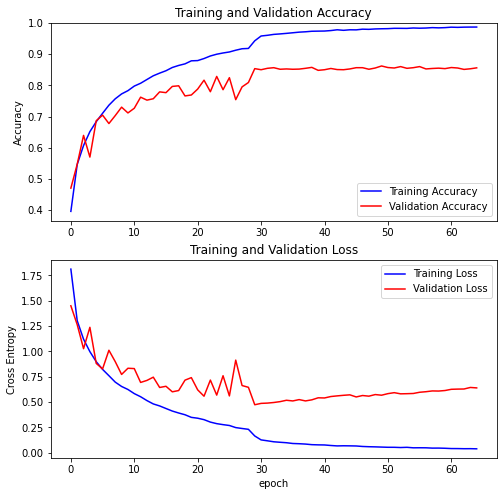

In [7]:
from utils.train_CIFAR_all import plot_model
plot_model(history)

In [8]:
print(history.history['acc'])
print(history.history['loss'])
print(history.history['val_acc'])
print(history.history['val_loss'])

[0.3959791660308838, 0.5465208292007446, 0.6069583296775818, 0.6514999866485596, 0.6833750009536743, 0.7103124856948853, 0.7362916469573975, 0.7568125128746033, 0.7724166512489319, 0.7828541398048401, 0.7975416779518127, 0.8066250085830688, 0.8186874985694885, 0.8306041955947876, 0.839062511920929, 0.8467291593551636, 0.8571666479110718, 0.8636875152587891, 0.8687916398048401, 0.8784999847412109, 0.8792708516120911, 0.885854184627533, 0.8940625190734863, 0.8996875286102295, 0.9036666750907898, 0.9068958163261414, 0.9125208258628845, 0.917229175567627, 0.9182083606719971, 0.9426875114440918, 0.9580625295639038, 0.9603124856948853, 0.9632291793823242, 0.9647708535194397, 0.9664999842643738, 0.9684374928474426, 0.9704166650772095, 0.9715833067893982, 0.9732916951179504, 0.9736666679382324, 0.9739791750907898, 0.9754999876022339, 0.9779999852180481, 0.9762916564941406, 0.9779791831970215, 0.9777500033378601, 0.9799374938011169, 0.9794166684150696, 0.9807083606719971, 0.9812708497047424, 0.

In [10]:
from utils.evaluate_model import score
# reload from saved weights:
model=custom_ResNeXt29(input_shape=(32,32,3),n_classes=10,cardinality=8,model_name='custom_ResNext29_8x64d')
model.load_weights(path)

if not os.path.exists('./full_models/cifar10'):
    os.makedirs('./full_models/cifar10')
model.save('./full_models/cifar10/ResNext29_best.h5')


score(model,X_test,y_test,top_n=[3,5])

313/313 - 13s - loss: 0.7287 - acc: 0.8287
custom_ResNext29_8x64d
model accuracy: 82.87%
top 3 accuracy: 96.52000069618225
top 5 accuracy: 99.08999800682068


# 2. Using SE_ResNeXt29_8x64d with CIFAR10

In [13]:
from utils.SE_ResNeXt import SE_ResNeXt29

SEResNeXt29=SE_ResNeXt29(input_shape=(32,32,3),n_classes=10,ratio=16,name='custom_ResNeXt29_SE')
#SEResNeXt.summary()

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau
import matplotlib.pyplot as plt

path='./models/cifar10/SE_ResNext29_best_cifar10.hdf5'
train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        width_shift_range=4, #+-8 pixel shift max
        height_shift_range=4)#+-8 pixel shift max


reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode='max',factor=0.1,
                              patience=5, min_lr=0.001, verbose=1)

#Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', patience=15)
# checkpoints
checkpoint = ModelCheckpoint(path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
SEResNeXt29.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9),loss='categorical_crossentropy', metrics = ['acc'])


train_generator = train_datagen.flow(X_train, y_train, batch_size=128)
step_size_train=train_generator.n//train_generator.batch_size

history=SEResNeXt29.fit(train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=200,
                    validation_data=(X_val,y_val),
                    callbacks=[reduce_lr,es,checkpoint])

Epoch 1/200
375/375 [==============================] - 82s 189ms/step - loss: 1.8576 - acc: 0.3535 - val_loss: 1.4103 - val_acc: 0.4970

Epoch 00001: val_acc improved from -inf to 0.49700, saving model to ./models/cifar10/SE_ResNext29_best_cifar10.hdf5
Epoch 2/200
375/375 [==============================] - 68s 182ms/step - loss: 1.2146 - acc: 0.5646 - val_loss: 1.3263 - val_acc: 0.5380

Epoch 00002: val_acc improved from 0.49700 to 0.53800, saving model to ./models/cifar10/SE_ResNext29_best_cifar10.hdf5
Epoch 3/200
375/375 [==============================] - 68s 182ms/step - loss: 1.0344 - acc: 0.6314 - val_loss: 1.1554 - val_acc: 0.5975

Epoch 00003: val_acc improved from 0.53800 to 0.59750, saving model to ./models/cifar10/SE_ResNext29_best_cifar10.hdf5
Epoch 4/200
375/375 [==============================] - 68s 182ms/step - loss: 0.9282 - acc: 0.6723 - val_loss: 1.3801 - val_acc: 0.5655

Epoch 00004: val_acc did not improve from 0.59750
Epoch 5/200
375/375 [===========================

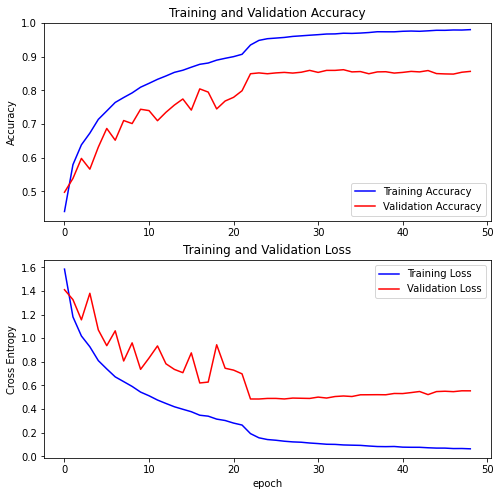

In [15]:
from utils.train_CIFAR_all import plot_model
plot_model(history)

In [16]:
print(history.history['acc'])
print(history.history['loss'])
print(history.history['val_acc'])
print(history.history['val_loss'])

[0.4397708475589752, 0.5788958072662354, 0.6378333568572998, 0.6726250052452087, 0.7133958339691162, 0.7384583353996277, 0.7637500166893005, 0.7783750295639038, 0.7921249866485596, 0.8090416789054871, 0.8205000162124634, 0.8323958516120911, 0.8423958420753479, 0.8531458377838135, 0.8594375252723694, 0.8684791922569275, 0.8770624995231628, 0.8808541893959045, 0.8893958330154419, 0.8948333263397217, 0.8998333215713501, 0.9067916870117188, 0.9344375133514404, 0.9481250047683716, 0.953083336353302, 0.9549375176429749, 0.9568750262260437, 0.9599166512489319, 0.9616458415985107, 0.9634583592414856, 0.9651041626930237, 0.9670416712760925, 0.9673749804496765, 0.9693750143051147, 0.968874990940094, 0.9698749780654907, 0.9714375138282776, 0.9737916588783264, 0.9736250042915344, 0.9735833406448364, 0.9751458168029785, 0.9758541584014893, 0.9751458168029785, 0.9764999747276306, 0.9781249761581421, 0.9779999852180481, 0.9790208339691162, 0.9788333177566528, 0.9800208210945129]
[1.58455228805542, 1.

In [17]:
# reload from saved weights:
model=SE_ResNeXt29(input_shape=(32,32,3),n_classes=10,ratio=16,name='custom_ResNeXt29_SE')
model.load_weights(path)

if not os.path.exists('./full_models/cifar10'):
    os.makedirs('./full_models/cifar10')
model.save('./full_models/cifar10/SE_ResNext29_best.h5')


score(model,X_test,y_test,top_n=[3,5])

313/313 - 14s - loss: 0.6006 - acc: 0.8309
SE_custom_ResNext29_8x64d
model accuracy: 83.09%
top 3 accuracy: 96.60000205039978
top 5 accuracy: 99.14000034332275
